In [7]:
import numpy as np
import pandas as pd

pd.set_option("display.precision", 3)

# some imports to set up plotting
import matplotlib.pyplot as plt

# !pip install seaborn
import seaborn as sns

# import some nice vis settings
sns.set()
# Graphics in the Retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import load_digits


Let’s draw some handwritten digits.

In [9]:


data = load_digits()
X, y = data.data, data.target

X[0, :].reshape([8, 8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Pictures here are 8x8 matrices (intensity of white color for each pixel). Then each such matrix is ​​“unfolded” into a vector of length 64, and we obtain a feature description of an object.

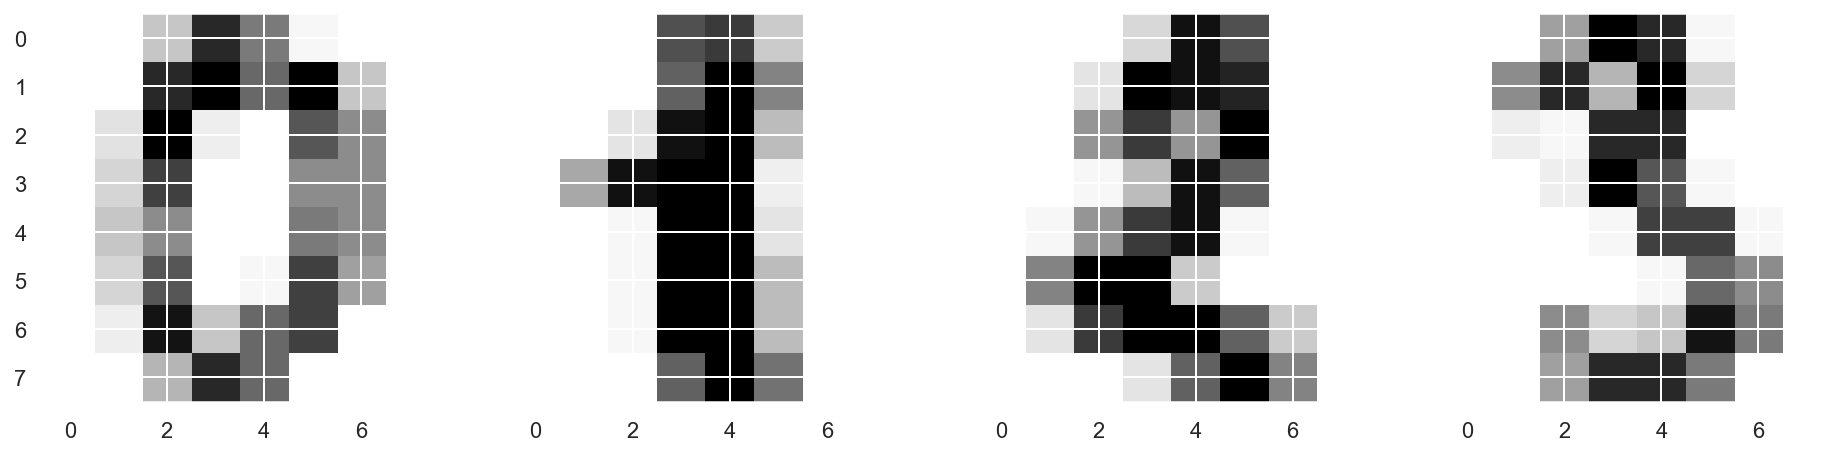

In [10]:

f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 6))
for i in range(4):
    axes[i].imshow(X[i, :].reshape([8, 8]), cmap="Greys");

70% of the dataset for training (X_train, y_train) and 30% for holdout (X_holdout, y_holdout)

The holdout set will not participate in model parameters tuning; we will use it at the end to check the quality of the resulting model.

In [12]:

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=17
)

In [13]:


tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=10))]
)

tree.fit(X_train, y_train)
knn_pipe.fit(X_train, y_train);

let’s make predictions on our holdout set

In [16]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn_pipe.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(
    y_holdout, tree_pred
)  # (0.976, 0.666)

(0.975925925925926, 0.6666666666666666)

Let’s tune our model parameters using cross-validation

In [18]:
tree_params = {
    "max_depth": [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
    "max_features": [1, 2, 3, 5, 10, 20, 30, 50, 64],
}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
                         'max_features': [1, 2, 3, 5, 10, 20, 30, 50, 64]},
             verbose=True)

best parameters combination and the corresponding accuracy 

In [19]:
tree_grid.best_params_, tree_grid.best_score_  # ({'max_depth': 20, 'max_features': 64}, 0.844)

({'max_depth': 10, 'max_features': 50}, 0.8568203376968316)

kNN works better on this dataset. In the case of one nearest neighbour, we were able to reach 99% guesses on cross-validation.

In [20]:
np.mean(
    cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5)
)  # 0.987

0.9864858028204642

Let’s train a random forest on the same dataset, it works better than kNN on the majority of datasets. But here we have an exception.

In [23]:
np.mean(
    cross_val_score(RandomForestClassifier(random_state=17), X_train, y_train, cv=5)
)  # 0.935

0.9753462341111744

we have not tuned any RandomForestClassifier parameters here. Even with tuning, the training accuracy doesn’t reach 98% as it did with one nearest neighbour.

First check simple models on your data: decision tree and nearest neighbors. It might be the case that these methods already work well enough.

In [24]:
def form_noisy_data(n_obj=1000, n_feat=100, random_seed=17):
    np.seed = random_seed
    y = np.random.choice([-1, 1], size=n_obj)

    # first feature is proportional to target
    x1 = 0.3 * y

    # other features are noise

    x_other = np.random.random(size=[n_obj, n_feat - 1])

    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y


X, y = form_noisy_data()

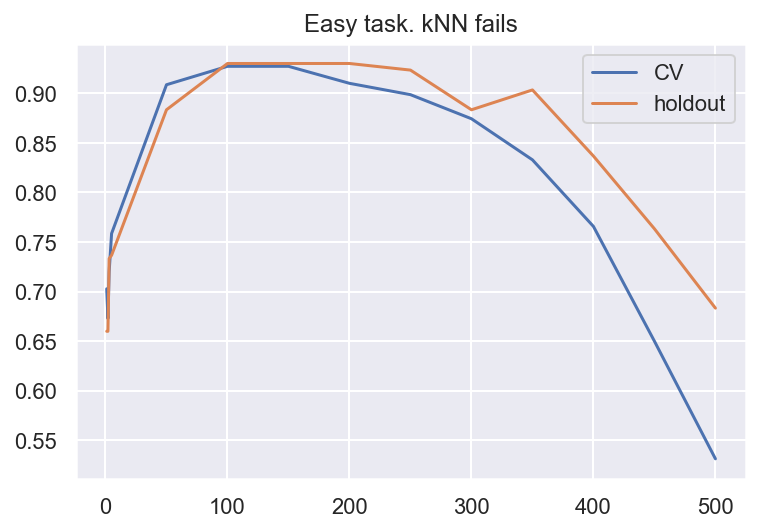

In [25]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.3, random_state=17
)

from sklearn.model_selection import cross_val_score

cv_scores, holdout_scores = [], []
n_neighb = [1, 2, 3, 5] + list(range(50, 550, 50))

for k in n_neighb:

    knn_pipe = Pipeline(
        [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=k))]
    )
    cv_scores.append(np.mean(cross_val_score(knn_pipe, X_train, y_train, cv=5)))
    knn_pipe.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn_pipe.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label="CV")
plt.plot(n_neighb, holdout_scores, label="holdout")
plt.title("Easy task. kNN fails")
plt.legend();

Construct curves reflecting the dependence of these quantities on the n_neighbors parameter in the method of nearest neighbors. These curves are called validation curves.

In [26]:
tree = DecisionTreeClassifier(random_state=17, max_depth=1)
tree_cv_score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
tree.fit(X_train, y_train)
tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))
print("Decision tree. CV: {}, holdout: {}".format(tree_cv_score, tree_holdout_score))

Decision tree. CV: 1.0, holdout: 1.0


The tree solved the problem perfectly while k-NN experienced difficulties.